<a href="https://colab.research.google.com/github/cindyy-chen/iss_movement/blob/main/Jan_2024_Tracking_the_International_Space_Station_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **<font color='green'>Step 0: Loading modules</font>**


In [26]:
!pip install global_land_mask
!pip install meteostat
!pip install movingpandas
!pip install hvplot
!pip install geopy
!pip install countryinfo
!pip install holoviews
!pip install reverse_geocode
!pip install catropy
!pip install geoview
!pip install shapely
!pip install geopandas

ERROR: Could not find a version that satisfies the requirement catropy (from versions: none)
ERROR: No matching distribution found for catropy
  Using cached geoview-0.0.1.tar.gz (3.8 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [27]:
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import requests

In [53]:
import time
import math
import json
import datetime as dt
from global_land_mask import globe
import reverse_geocode

In [28]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [29]:
import os
import numpy as np

In [31]:
import meteostat as met

In [32]:
from geopy.geocoders import Nominatim
from countryinfo import CountryInfo
from shapely import geometry as shpgeom
from shapely import wkt as shpwkt
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import hvplot.pandas
from countryinfo import CountryInfo
from geopy.geocoders import Nominatim

In [33]:
import holoviews as hv
import hvplot.pandas
from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
hv.opts.defaults(hv.opts.Overlay(active_tools=['wheel_zoom'],
                              frame_width=500, frame_height=400))
hvplot_defaults = {'tiles':None, 'cmap':'Viridis', 'colorbar':True}

In [35]:
mpd.show_versions()


MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
executable : /usr/bin/python3
machine    : Linux-6.1.58+-x86_64-with-glibc2.35

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: /usr/local/lib/python3.10/dist-packages/fiona/gdal_data
PROJ       : 9.3.0
PROJ data dir: /usr/local/lib/python3.10/dist-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.13.2
pandas     : 1.5.3
fiona      : 1.9.5
numpy      : 1.25.2
shapely    : 2.0.2
rtree      : 1.2.0
pyproj     : 3.6.1
matplotlib : 3.7.1
mapclassify: None
geopy      : 2.3.0
holoviews  : 1.17.1
hvplot     : 0.9.2
geoviews   : None
stonesoup  : None


---
# **<font color='green'>Step 1: Read the CSV File</font>**

In [ ]:
file_name = "https://raw.githubusercontent.com/cindyy-chen/iss_movement/main/iss_timeseries_trajectories_20240217_130914.csv"
df = pd.read_csv(file_name, sep=",")
df

In [38]:
# from google.colab import drive
# drive.mount('/content/drive')
# !ls drive/MyDrive/iss*

In [39]:
# file_dir = "/content/drive/My Drive/"
# os.listdir(file_dir)
# file_name = os.path.join(file_dir, "iss_timeseries_trajectories_20230921_165844.csv")

In [40]:
# file_name = "/content/drive/My Drive/iss_timeseries_trajectories_20230921_165844.csv"
# df = pd.read_csv(file_name, sep=",")
# df

---
# **<font color='green'>Step 2: Perform Conversions</font>**

Convert longitude from 0 to 360 into -180 to 180:

In [41]:
df['longitude'] = (df['longitude'] + 180) % 360 - 180

Convert the positions (latitude and longitude) into Shapely POINT objects:

In [42]:
df['geometry'] = [shpgeom.Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df

,t,latitude,longitude,land_flag,temperature,windspeed,traj_id,country,geometry
0,2024-02-17 13:09:14,-19.3273,-31.2277,False,28.2,13.8,0,Brazil,POINT (-31.2277 -19.3273)
1,2024-02-17 13:09:20,-19.5952,-31.0024,False,27.9,12.0,0,Brazil,POINT (-31.002399999999994 -19.5952)
2,2024-02-17 13:09:25,-19.8627,-30.7763,False,28.0,10.9,0,Brazil,POINT (-30.776299999999992 -19.8627)
3,2024-02-17 13:09:31,-20.1542,-30.5287,False,28.0,11.2,0,Brazil,POINT (-30.528700000000015 -20.1542)
4,2024-02-17 13:09:37,-20.4210,-30.3008,False,27.8,12.1,0,Brazil,POINT (-30.30080000000001 -20.421)
...,...,...,...,...,...,...,...,...,...
1996,2024-02-17 16:16:19,-23.3906,-74.8537,False,20.6,34.3,2,Chile,POINT (-74.8537 -23.3906)
1997,2024-02-17 16:16:24,-23.6525,-74.6142,False,20.4,35.6,2,Chile,POINT (-74.6142 -23.6525)
1998,2024-02-17 16:16:30,-23.9376,-74.3518,False,20.3,36.1,2,Chile,POINT (-74.3518 -23.9376)
1999,2024-02-17 16:16:36,-24.1985,-74.1101,False,20.6,35.8,2,Chile,POINT (-74.1101 -24.1985)


Convert time to datetime object:

In [57]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df

KeyError: 'timestamp'

In [ ]:
df.rename(columns={'timestamp': 't'}, inplace=True)
df['t'] = df.apply(lambda row: row['t'].to_pydatetime(), axis=1)
df

AttributeError: 'str' object has no attribute 'to_pydatetime'

---

# **<font color='green'>Step 3: Create Moving Pandas Trajectories</font>**


In [58]:
df.columns = ['latitude', 'longitude', 't', 'traj_id', 'geometry']
df = df.set_index('t')
df

ValueError: Length mismatch: Expected axis has 9 elements, new values have 5 elements

---
# **<font color='green'>Step 4: Gather Weather Data</font>**


In [ ]:
def get_weather_data(lat, lon, dt_obj):

    """
    Given a location (latitude/longitude) and a date/time, determine the weather condition at the location.
    Parameters
    ----------
    lat : float
       The latitude.
    lon : float
       The longitude.
    dt_obj : datetime object
       The date and time.

    Return
    ----------
    data : Pandas DataFrame
       Weather condition at the location.
    """

    location = met.Point(lat, lon)
    start_date = dt_obj
    end_date = start_date + dt.timedelta(seconds=4)
    data = met.Hourly(location, start_date, end_date)
    return data.fetch()

In [ ]:
dt_obj = dt.datetime(2023, 8, 1)
lat = 49.2497
lon = -123.1193
data = get_weather_data(lat, lon, dt_obj)

In [ ]:
data

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2023-08-01,23.9,10.2,42.0,0.0,NaN,258.0,13.3,NaN,1018.9,NaN,3.0


In [ ]:
def create_columns(row):
    try:
        data = get_weather_data(row["latitude"], row["longitude"], row["t"])

        if len(data):
            temp = data.get("tavg", [-9999.])[0]
            precip = data.get("prcp", [-9999.])[0]
            pres = data.get("pres", [-9999.])[0]
        else:
            temp = precip = pres = -9999.0

    except (KeyError, IndexError):
        temp = precip = pres = -9999.0

    return [temp, precip, pres]

In [ ]:
df[["temp", "precip", "pres"]] = df.apply(create_columns, axis=1, result_type="expand")
df

TypeError: can only concatenate str (not "datetime.timedelta") to str

In [59]:
df[df==-9999.0] = np.nan
df

,t,latitude,longitude,land_flag,temperature,windspeed,traj_id,country,geometry
0,2024-02-17 13:09:14,-19.3273,-31.2277,False,28.2,13.8,0,Brazil,POINT (-31.2277 -19.3273)
1,2024-02-17 13:09:20,-19.5952,-31.0024,False,27.9,12.0,0,Brazil,POINT (-31.002399999999994 -19.5952)
2,2024-02-17 13:09:25,-19.8627,-30.7763,False,28.0,10.9,0,Brazil,POINT (-30.776299999999992 -19.8627)
3,2024-02-17 13:09:31,-20.1542,-30.5287,False,28.0,11.2,0,Brazil,POINT (-30.528700000000015 -20.1542)
4,2024-02-17 13:09:37,-20.4210,-30.3008,False,27.8,12.1,0,Brazil,POINT (-30.30080000000001 -20.421)
...,...,...,...,...,...,...,...,...,...
1996,2024-02-17 16:16:19,-23.3906,-74.8537,False,20.6,34.3,2,Chile,POINT (-74.8537 -23.3906)
1997,2024-02-17 16:16:24,-23.6525,-74.6142,False,20.4,35.6,2,Chile,POINT (-74.6142 -23.6525)
1998,2024-02-17 16:16:30,-23.9376,-74.3518,False,20.3,36.1,2,Chile,POINT (-74.3518 -23.9376)
1999,2024-02-17 16:16:36,-24.1985,-74.1101,False,20.6,35.8,2,Chile,POINT (-74.1101 -24.1985)


In [60]:
df.isnull().sum()

t              0
latitude       0
longitude      0
land_flag      0
temperature    0
windspeed      0
traj_id        0
country        0
geometry       0
dtype: int64

---

# **<font color='green'>Step 5: Determine if a location is on land/water</font>**



In [ ]:
# print(globe.is_land(49.22, -2.23))
# print(globe.is_land(49.22, -2.25))

Add land/water column:

In [61]:
df["Land"] = df.apply(lambda row: globe.is_land(row["latitude"], row["longitude"]), axis=1)
df

,t,latitude,longitude,land_flag,temperature,windspeed,traj_id,country,geometry,Land
0,2024-02-17 13:09:14,-19.3273,-31.2277,False,28.2,13.8,0,Brazil,POINT (-31.2277 -19.3273),False
1,2024-02-17 13:09:20,-19.5952,-31.0024,False,27.9,12.0,0,Brazil,POINT (-31.002399999999994 -19.5952),False
2,2024-02-17 13:09:25,-19.8627,-30.7763,False,28.0,10.9,0,Brazil,POINT (-30.776299999999992 -19.8627),False
3,2024-02-17 13:09:31,-20.1542,-30.5287,False,28.0,11.2,0,Brazil,POINT (-30.528700000000015 -20.1542),False
4,2024-02-17 13:09:37,-20.4210,-30.3008,False,27.8,12.1,0,Brazil,POINT (-30.30080000000001 -20.421),False
...,...,...,...,...,...,...,...,...,...,...
1996,2024-02-17 16:16:19,-23.3906,-74.8537,False,20.6,34.3,2,Chile,POINT (-74.8537 -23.3906),False
1997,2024-02-17 16:16:24,-23.6525,-74.6142,False,20.4,35.6,2,Chile,POINT (-74.6142 -23.6525),False
1998,2024-02-17 16:16:30,-23.9376,-74.3518,False,20.3,36.1,2,Chile,POINT (-74.3518 -23.9376),False
1999,2024-02-17 16:16:36,-24.1985,-74.1101,False,20.6,35.8,2,Chile,POINT (-74.1101 -24.1985),False


---
# **<font color='green'>Step 6: Plotting the trajectories of ISS</font>**



In [62]:
iss_gdf = gpd.GeoDataFrame(df, geometry="geometry")
iss_gdf

,t,latitude,longitude,land_flag,temperature,windspeed,traj_id,country,geometry,Land
0,2024-02-17 13:09:14,-19.3273,-31.2277,False,28.2,13.8,0,Brazil,POINT (-31.22770 -19.32730),False
1,2024-02-17 13:09:20,-19.5952,-31.0024,False,27.9,12.0,0,Brazil,POINT (-31.00240 -19.59520),False
2,2024-02-17 13:09:25,-19.8627,-30.7763,False,28.0,10.9,0,Brazil,POINT (-30.77630 -19.86270),False
3,2024-02-17 13:09:31,-20.1542,-30.5287,False,28.0,11.2,0,Brazil,POINT (-30.52870 -20.15420),False
4,2024-02-17 13:09:37,-20.4210,-30.3008,False,27.8,12.1,0,Brazil,POINT (-30.30080 -20.42100),False
...,...,...,...,...,...,...,...,...,...,...
1996,2024-02-17 16:16:19,-23.3906,-74.8537,False,20.6,34.3,2,Chile,POINT (-74.85370 -23.39060),False
1997,2024-02-17 16:16:24,-23.6525,-74.6142,False,20.4,35.6,2,Chile,POINT (-74.61420 -23.65250),False
1998,2024-02-17 16:16:30,-23.9376,-74.3518,False,20.3,36.1,2,Chile,POINT (-74.35180 -23.93760),False
1999,2024-02-17 16:16:36,-24.1985,-74.1101,False,20.6,35.8,2,Chile,POINT (-74.11010 -24.19850),False


<Axes: >

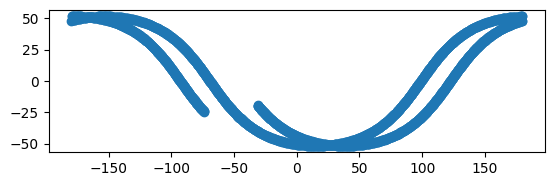

In [63]:
# general trajectories
iss_gdf.plot()

<Axes: >

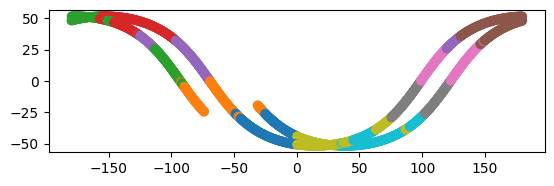

In [64]:
# trajectories color coded by country

# iss_gdf.plot("country")

iss_gdf.plot("geometry")
# you have to make it sort the colors by geometry instead of country or else it will just sort it alphabetically

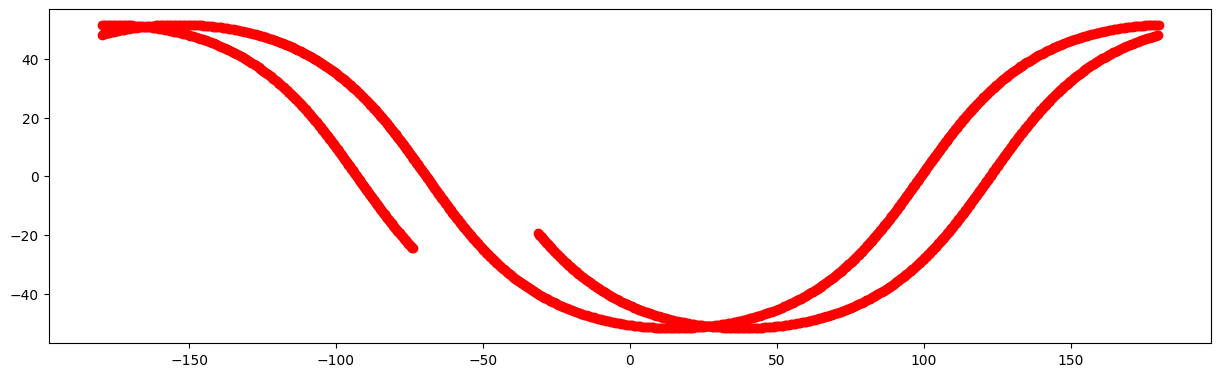

In [65]:
gdf_path = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'})
gdf_path.plot(figsize=(15,10), color='red');

In [66]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


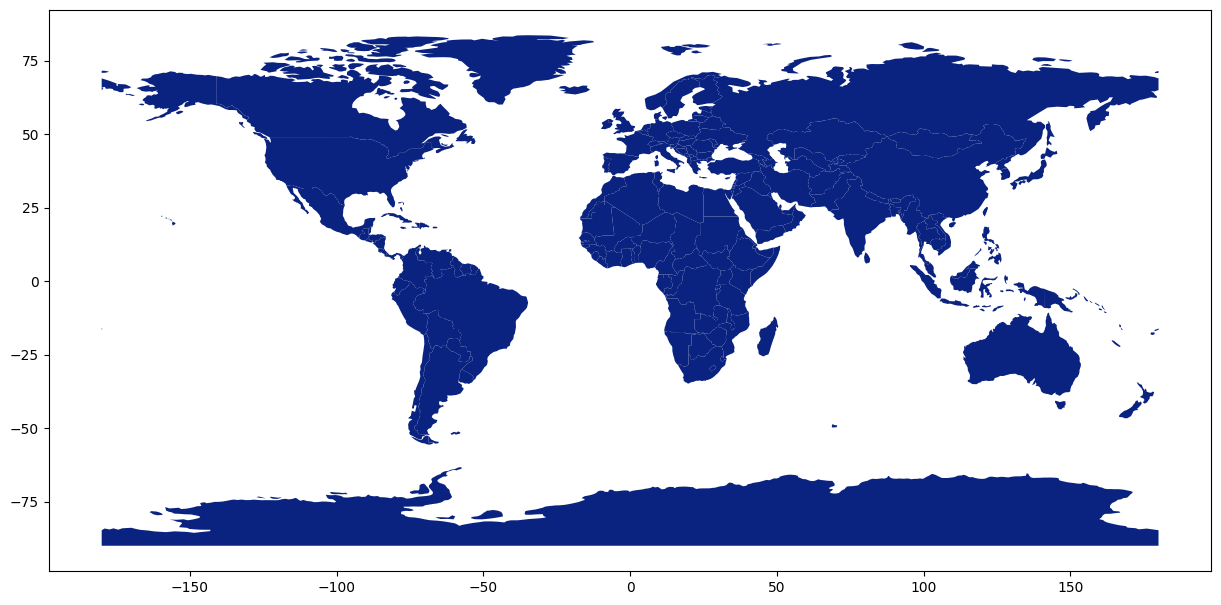

In [67]:
# world map
world.plot(figsize=(15,10),  color='#0B2380');

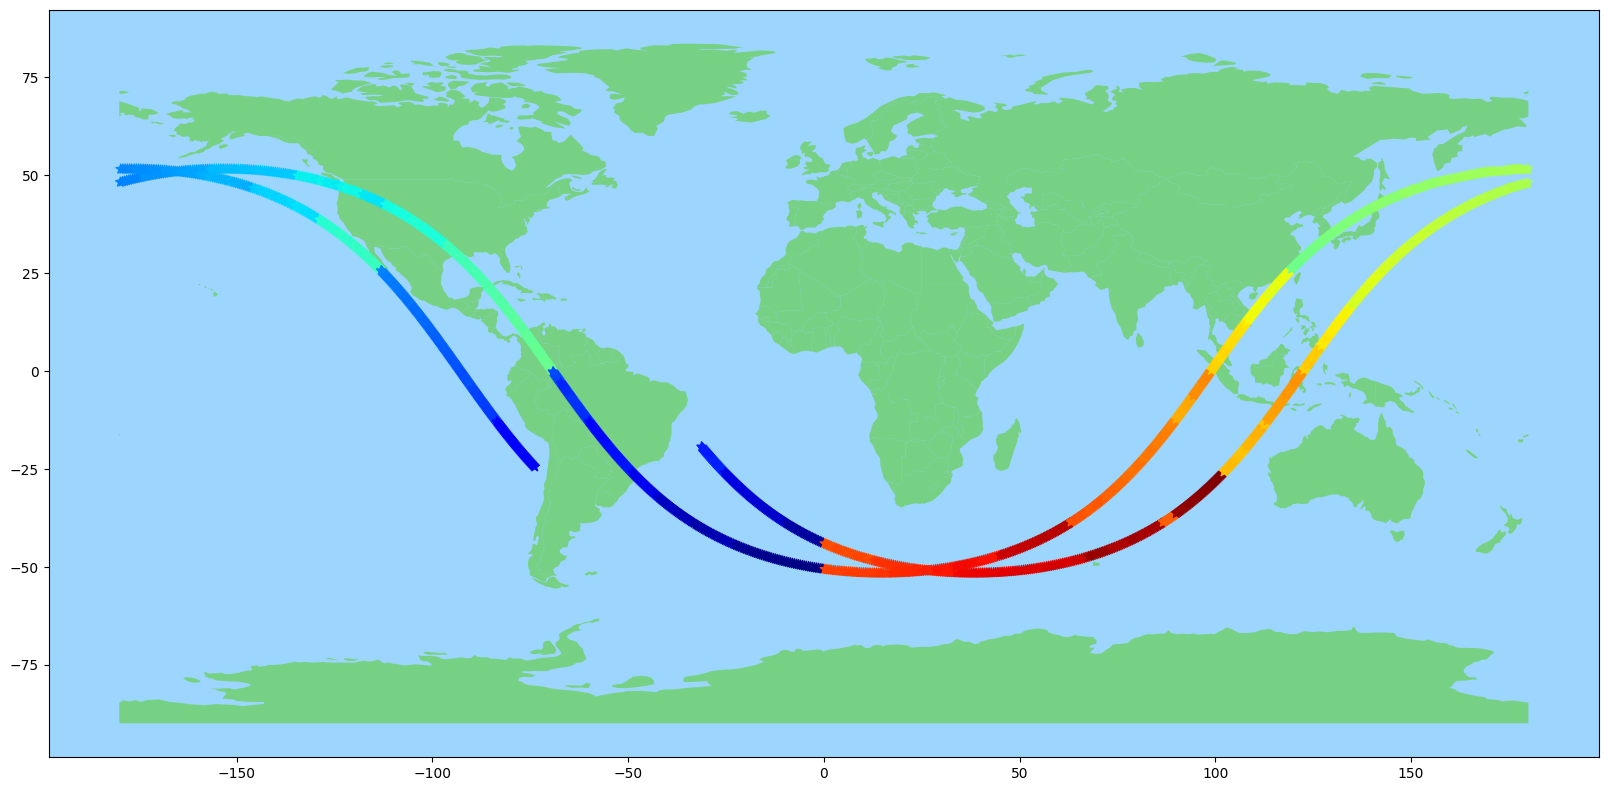

In [68]:
# plotting iss position over earth

# fig, ax = plt.subplots(1, figsize=(15,10))
# base = world.plot(ax=ax, color='#6eff82',)
# base.set_facecolor('#9CD6FF')
# iss_gdf.plot("country", ax=base, marker="*", markersize=30, cmap = 'jet');


fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='#77d184',)
base.set_facecolor('#9CD6FF')
iss_gdf.plot("geometry", ax=base, marker="*", markersize=50, cmap = 'jet');

# geometry instead of country

<Axes: >

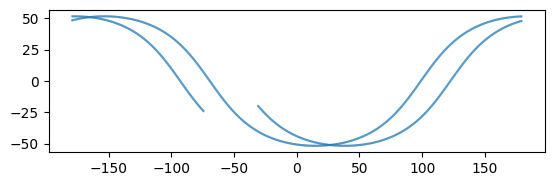

In [69]:
iss_trajc = mpd.TrajectoryCollection(gdf_path,
                                 x = "longitude", y="latitude",
                                 traj_id_col="traj_id", t="t")
iss_trajc.plot()

---
# **<font color='green'>Step 7: Create interactive plots</font>**



In [ ]:
iss_trajc.trajectories[1].plot(legend="true", column="temp")